# A copy of the F=ma model, but it doesn't normalize input data.

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial # Import this due to weird lambda behavior
%load_ext tensorboard

import dill
import datetime as dt

## Generate training data (incl. noise)

Define input functions here.

In [22]:
# Random input 
# def rand_input(t, mean=0, variance=1):
#     # Arguments:
#     # t: A scalar time step - useless
#     # mean: Mean of generated random Gaussian input
#     # variance: Variance of generated input
#     return np.random.normal(mean, variance)

def rand_input_func(t_interval=[0,1], dt=0.1, mean=0, variance=1):
    # Arguments:
    # t_interval: Start and stop time
    # dt: Interval between provided data points for interpolation
    # mean: Mean of generated random Gaussian input
    # variance: Variance of generated input
    # Returns: A function that takes in time as input and returns the interpolation
    #          at that time using the generated random data.

    ts = np.arange(t_interval[0], t_interval[1], dt)
    # Include fill_value="extrapolate" in returned function so that out-of-bounds requests can still be accepted
    return interp1d( ts, np.random.normal(mean, variance, ts.shape), fill_value="extrapolate" )
#     return np.array([mean + variance * np.random. for t in ts.flatten()]).reshape(ts.shape)

def rand_sin_input_func(t_interval=[0,1], dt=0.1, amp=1, freq=1, phase=0, mean=0, variance=1):
    # Arguments:
    # t_interval: Start and stop time
    # dt: Interval between provided data points for interpolation
    # amp, freq, phase: Parameters for the base sinusoid
    # mean: Mean of generated random Gaussian input (can also be seen as offset for sinusoid)
    # variance: Variance of generated input
    # Returns: A function that takes in time as input and returns the interpolation
    #          at that time using the generated random data.
    ts = np.arange(t_interval[0], t_interval[1], dt)
    # Include fill_value="extrapolate" in returned function so that out-of-bounds requests can still be accepted
    rand_func = interp1d( ts, np.random.normal(mean, variance, ts.shape), fill_value="extrapolate", kind='cubic')
    # Define the final function to be returned
    def input_generation(t, rand_func=rand_func):
        return amp * np.sin( freq * t + phase ) + rand_func(t)
    return input_generation

In [ ]:
# Just a short piece of code that demonstrate this works, or should work
ts = np.arange(0,10,1)
rand_func = interp1d( ts, np.random.normal(0, 1, ts.shape), fill_value="extrapolate", kind='cubic')
testts = np.arange(0,10,0.1)
plt.plot(testts, np.array([rand_func(t) for t in testts]))

## Data synthesizer for F=ma

In [70]:
# Function that outputs dynamics dx/dt when given current states
def fma(x, t, u=lambda x : 0):
    # Arguments: x = [velocity, position]^T, t = current time.
    # Output: dx/dt= [input u , velocity]^T
    # Assumes scalar.
    return np.array([x[1], u(t)])

# Synthesizes data based on input. Uses odeint solver.
def fma_generator(t_interval=[0,1], dt=0.01, init=None, u=lambda x : 0):
    # Arguments: [start time, end time], time interval, initial conditions, input function
    t = np.arange(t_interval[0], t_interval[1], dt)
    if init is None:
        init = np.array([0, 0])
    x = odeint(func=fma, y0=init, t=t, args=(u,)) # (u,) creates an one-element tuple
    # Returns an array where first row is time, and 2nd~last rows are states
    return np.vstack((t, x.T))

# Generate data similar to the above procedure, but this time in function
def fma_batch_generator(t_list, u_list, init_conds=None, dt=0.01, noise_level=0):
    # Arguments: 
    # t_list: List of start-end time tuples
    # u_list: list of input functions
    # Outputs:
    # time_input_data: List of array containing time information and input information (per row)
    # output_data: List of array containing all observed states (per row) matching the time row
    # seg_ind_list: Auxiliary index information for each different input segment
    
    data_list = []
    input_list = []
    
    Nseg = t_list.shape[1]
    # Initial conditions of each segment
    if init_conds is None:
        init_conds = np.zeros((2, Nseg))
    
    # Generate data for each segment
    for i in range(Nseg):
        data_list.append( fma_generator(t_list[:,i], dt, init_conds[:,i], u_list[i]) )
        # Regenerate time history
        input_list.append( [u_list[i](t) for t in data_list[i][0,:]] )
    seg_ind_list = [0] + [data_list[i].shape[1] for i in range(Nseg)]
    seg_ind_list = np.cumsum(seg_ind_list)
    
    # Put together as one matrix with time-input data, and one with output data.
    # Don't concatenate them into one full array yet - let the framing function do this.
    time_input_data = [ np.vstack((data_list[i][0,:], input_list[i])) for i in range(Nseg) ]
    output_data = [ data_list[i][2,None,:] for i in range(Nseg) ]
    # Amazing find: Adding that "None" in the 3rd dimension forces the slice to be 2D. AaaaaaAAA
    # Source: https://stackoverflow.com/a/32764336
    # Use [i,:,None] for vertical, and [i,None,:] for horizontal.
    
#     data_list = np.concatenate(data_list, axis=1)
#     input_list = np.concatenate(input_list)
#     time_input_data = np.vstack((data_list[0,:], input_list))
#     output_data = np.reshape(data_list[2,:], (1, data_list.shape[1])) # Only position is observed
    
    # Add noise to observation. 
    for i in range(Nseg):
        output_data[i] += output_data[i] * noise_level * np.random.randn(1, output_data[i].shape[-1])
#     output_data += noise_level * output_data * np.random.randn(1, output_data.shape[-1])
    
    return time_input_data, output_data, seg_ind_list

# For this case, we excite the system with sinusoidal inputs.
# Additionally, we regulate the form of time, so that the NN gets less surprise.
Nd_seg = 1000
Nseg = 10
dt = 0.01
t_list = np.array([[0,(Nd_seg+2)*dt]] * Nseg).T # The "+2" is to prevent extrapolation from going crazy
u_func_list = []
noise_level = 0#.1

# # Sinusoidal input:
# u_params = np.vstack((
#     np.random.uniform(0.5, 1, (1, Nseg)), # Magnitudes
#     np.random.uniform(0.02, 0.25, (1, Nseg))*np.pi*2, # frequencies
#     np.random.uniform(0, np.pi, (1,Nseg)) # Phases
# ))
# u_func_list += [partial(lambda t,i : u_params[0,i] * np.sin(u_params[1,i]*t+u_params[2,i]), i=j) for j in range(Nseg)]

# # Random input:
# u_params_r = np.vstack((
#     np.random.uniform(-1, 1, (1, Nseg)), # Means
#     np.random.uniform(0.4, 1, (1, Nseg)) # Variances
# ))
# u_func_list += [rand_input_func(t_list[:,i], 0.1, u_params_r[0,i], u_params_r[1,i]) for i in range(Nseg)]

# Random input on a sinusoidal base:
u_params = np.vstack((
    np.random.uniform(0.5, 1, (1, Nseg)), # Magnitudes
    np.random.uniform(0.02, 0.25, (1, Nseg))*np.pi*2, # frequencies
    np.random.uniform(0, np.pi, (1,Nseg)), # Phases
    np.random.uniform(-1, 1, (1, Nseg)), # Means
    np.random.uniform(0.4, 1, (1, Nseg)) # Variances
))
u_func_list += [ rand_sin_input_func(t_list[:,i], 0.5, u_params[0,i], u_params[1,i], 
                                     u_params[2,i], u_params[3,i], u_params[4,i]) for i in range(Nseg) ]

Nseg = len(u_func_list)
t_list = np.array([[0,Nd_seg*dt]] * Nseg).T
(Inputset, Outputset, seg_ind_list) = fma_batch_generator(t_list, u_func_list, dt=dt, noise_level=noise_level)

## Data batch preprocessor

In [24]:
# Segments input data into numerous training timeframes
def framing(input_data, output_data, data_ind, frame_size, pred_size=1):
    # Arguments:
    # input_data: The training input data that is to be made into overlapping frames. Should be 2D.
    # output_data: The labels of corresponding input data. Will be made into matching frames.
    # data_ind: The indices where data from a new segment starts.
    # Outputs:
    # input_frames: An array of frames, in the shape of (Nframes, <2D frame shape>)
    # output_frames: An array of outputs corresponding to each frame in input_frames
    # pred_frames: An array of future frames corresponding to each frame in input_frames
    # frames_ind: A list detailing the index where a frame from a different segment starts.
    
    Ninputrow = input_data[0].shape[0]
    Noutputrow = output_data[0].shape[0]
    print(Noutputrow)
    # Generate data by splitting it into successive overlapping frames.
    # Its first dimension is going to be samples. Each 2D sample occupies the 2nd and 3rd.
    # Empty lists to hold the results:
    input_frames = []
    output_frames = []
    pred_frames = []
    frames_ind = [0]
    # Process each segment
    for i in range(len(data_ind)-1):
        Nframes = data_ind[i+1]-data_ind[i] - pred_size - frame_size
        inframes = np.zeros((Nframes, Ninputrow, frame_size))
        outframes = np.zeros((Nframes, Noutputrow, 1)) # Assuming scalar output
#         outdata = np.reshape(output_data[i], (-1,output_data[i].shape[-1])) # Force into 2D
#         outframes = np.zeros((Nframes, outdata[i].shape[0], 1)) # Assuming scalar output
        predframes = np.zeros((Nframes, Ninputrow, pred_size))
        
        # Put into frames
        for j in range(Nframes):
            inframes[j,:,:] = input_data[i][:,j:j+frame_size]
            outframes[j,:,:] = output_data[i][:,j+frame_size-1] # Output at the final timestep
        
        # Also offer complementary future state if you're into predictions
        if pred_size > 0:
            for j in range(Nframes):
                predframes[j,:,:] = input_data[i][:, j+frame_size:j+frame_size+pred_size]
        
        input_frames.append(inframes)
        output_frames.append(outframes)
        pred_frames.append(predframes)
        frames_ind.append(Nframes)
    
    # Combine everything into arrays
    input_frames = np.concatenate(input_frames)
    output_frames = np.concatenate(output_frames)
    pred_frames = np.concatenate(pred_frames)
    frames_ind = np.cumsum(frames_ind)
    
    return input_frames, output_frames, pred_frames, frames_ind


In [46]:
# WHAT: https://stackoverflow.com/a/34021333
# from functools import partial
# fff = [partial(lambda t,i : t*i+i*i, i=j) for j in [0,1,2]]
# The above is the right way. The two ways below don't give the right results.
# fff = [(lambda t : t*i+i*i) for i in [0,1,2]]
# fff=[]
# for i in range(3):
#     temp_f = lambda t : t*i+i*i
#     fff.append( temp_f )
# print( fff[0](1), fff[1](1), fff[2](1) )
# np.vstack((np.array([1,2,3]), [4,5,6]))
# aaa = np.array([[1,2,3],[3,2,1]])
# aaa = aaa[0,None,:]
# print(aaa.shape, aaa)
# Inputset[10].shape
InputFset.shape


(9960, 1, 1)

## Plot training data for visual inspection

Text(0.5, 0.98, 'Training data')

<Figure size 432x288 with 0 Axes>

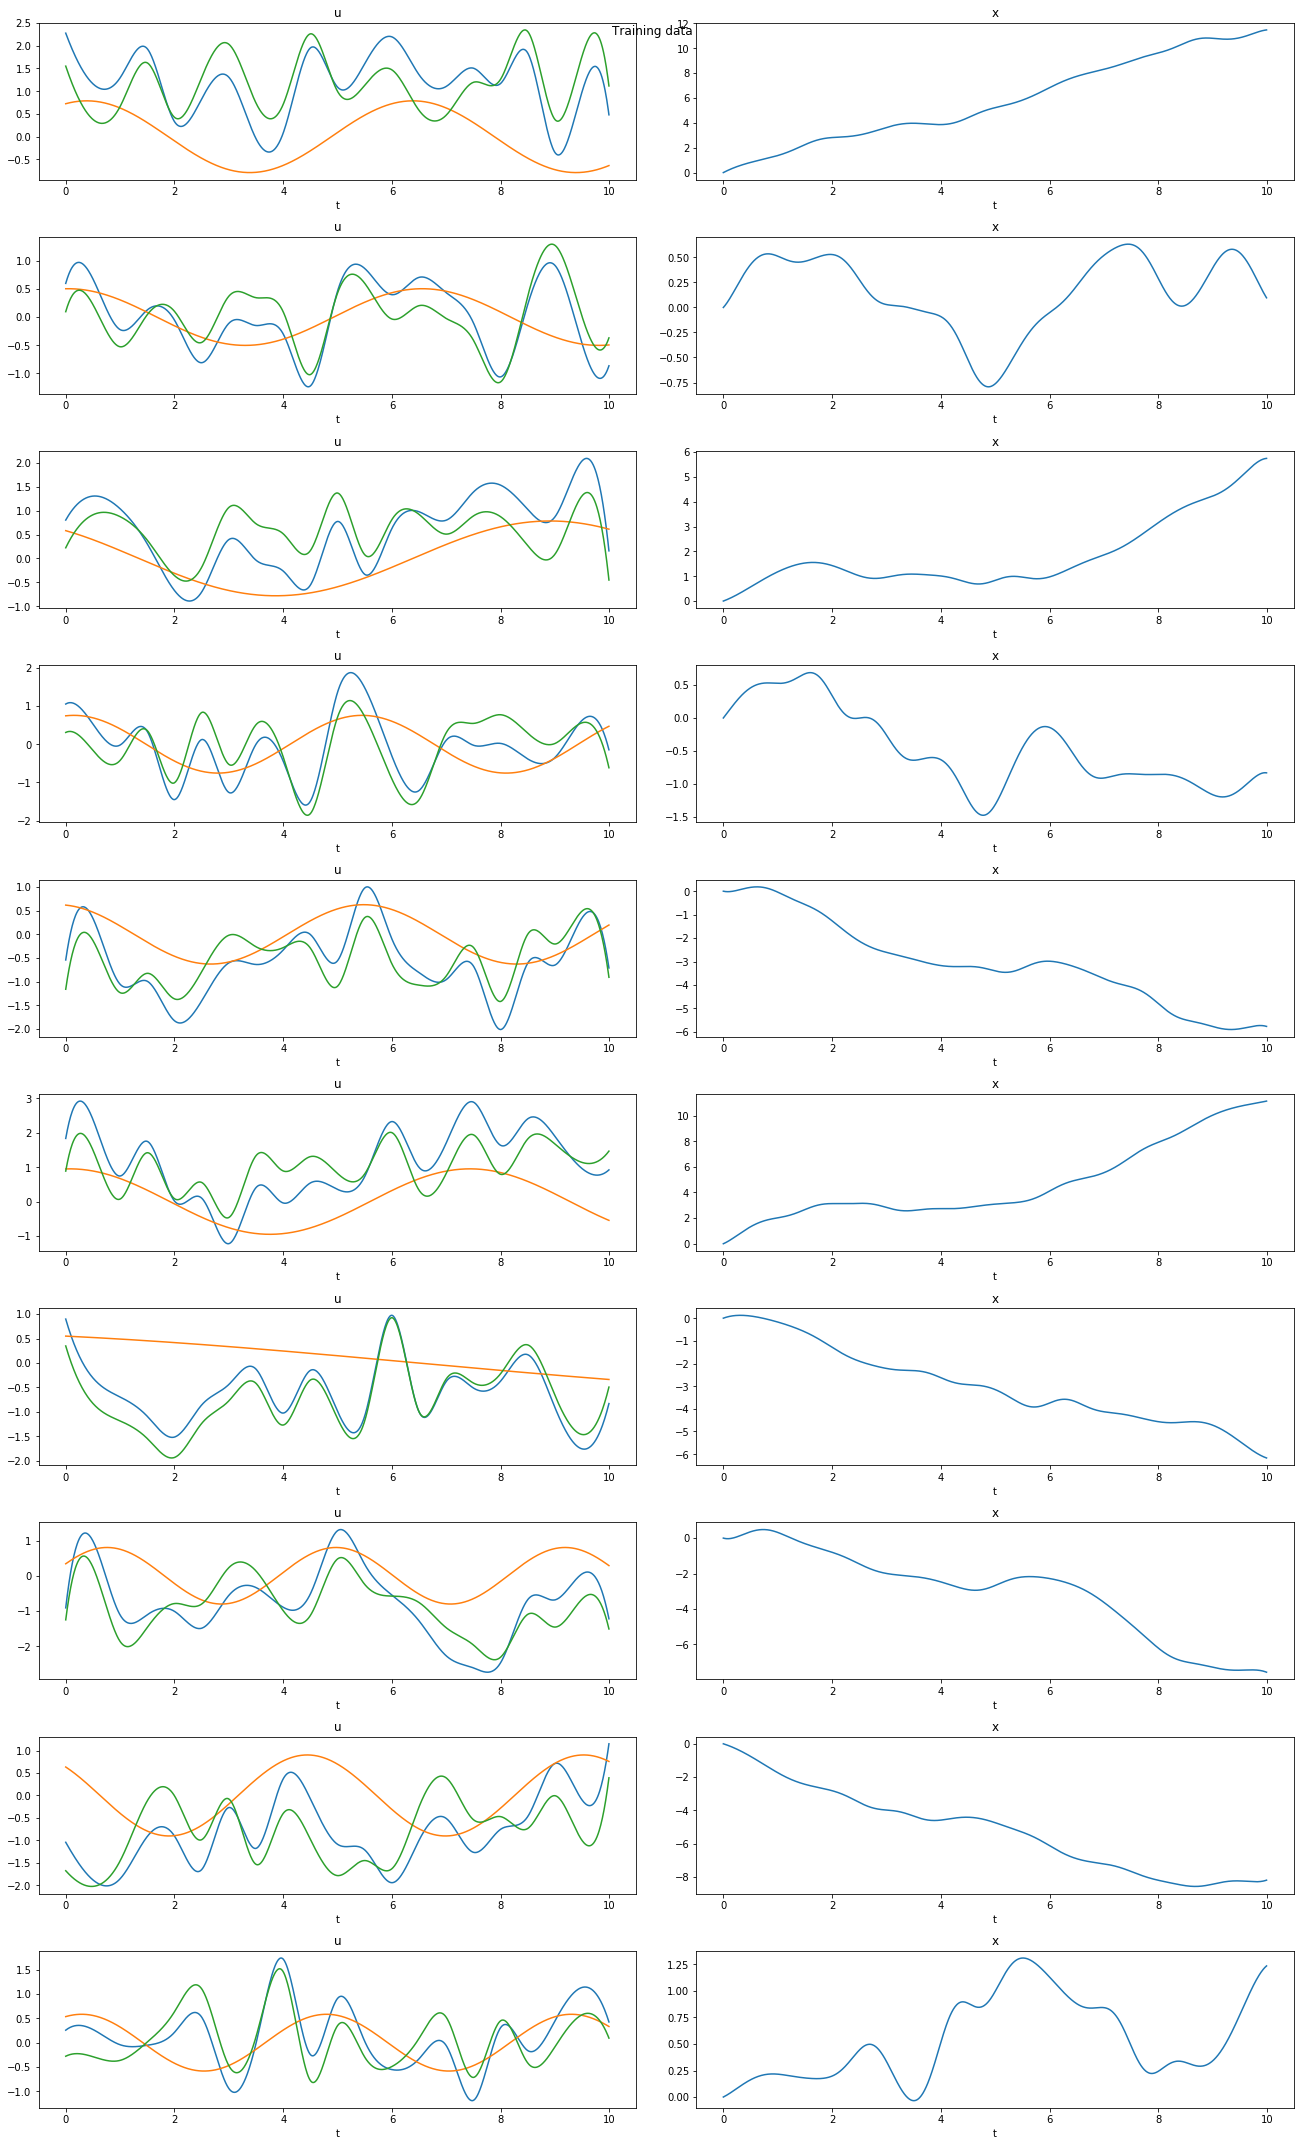

In [71]:
plt.clf()
fig,axs = plt.subplots(Nseg, 2, constrained_layout=True, figsize = (18,30))

# Generate correct answer for each test, as well as run input through prediction
plot_skip_rate = 1 # Only plot a point for every this number of samples
for i in range(Nseg):
    # Plot both cases
    axs[i][0].plot(Inputset[i][0,::plot_skip_rate], Inputset[i][1,::plot_skip_rate])
    axs[i][0].plot(Inputset[i][0,::plot_skip_rate], u_params[0,i] * np.sin(
        u_params[1,i] * Inputset[i][0,::plot_skip_rate] + u_params[2,i])) # Underlying sine model
    axs[i][0].plot(Inputset[i][0,::plot_skip_rate], Inputset[i][1,::plot_skip_rate] - u_params[0,i] * np.sin(
        u_params[1,i] * Inputset[i][0,::plot_skip_rate] + u_params[2,i])) # Added noise interpolation
    axs[i][0].set_title('u')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(Inputset[i][0,::plot_skip_rate], Outputset[i][0,::plot_skip_rate])
    axs[i][1].set_title('x')
    axs[i][1].set_xlabel('t')
fig.suptitle('Training data')

In [ ]:
# np.save('./datasets/rand_input_Inputset.npy',Inputset)
# np.save('./datasets/rand_input_Outputset.npy',Outputset)
# np.save('./datasets/rand_input_seg_ind_list.npy',seg_ind_list)

# Construct neural nets

In [30]:
# Set seed to ensure reprodicibility
tf.random.set_seed(2020)

# Set log directory for tensorboard visualization later
log_dir = "fma_framed_logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train_prep(seed=2020):
    # Clear previous model
    tf.keras.backend.clear_session()
    # Clear any Tensorboard logs from previous runs
    !rm -rf ./fma_framed_logs/ 
    tf.random.set_seed(seed)
    
    

## Single-timestep input nets
Don't expect them to work well

In [95]:
# 1-layer, each with 4 LSTM neurons
train_prep()

# Generate data
frame_size = 4
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)
train_dataset = tf.data.Dataset.from_tensor_slices((InputFset,OutputFset))

Activation = tf.keras.activations.tanh
Nneuron = 4
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.LSTM(Nneuron, activation = Activation, input_shape = InputFset.shape[-2:]),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 1
Epoch = 100

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

1


In [96]:
train_dataset

<TensorSliceDataset shapes: ((2, 4), (1, 1)), types: (tf.float64, tf.float64)>

In [ ]:
# 2-layer, each with 4 neurons
train_prep()

# Generate data
frame_size = 1
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

Activation = tf.keras.activations.tanh
Nneuron = 4
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = (InputFset.shape[1],InputFset.shape[2])),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 2
Epoch = 20

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [ ]:
# 4-layer, each with 16 neurons... Too complicated!
train_prep()

# Generate data
frame_size = 1
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

Activation = tf.keras.activations.tanh
Nneuron = 16
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = (InputFset.shape[1],InputFset.shape[2])),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(Nneuron, activation = Activation),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 4
Epoch = 40

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

Train

In [ ]:
# Note: Might need to tune parameters such as batch_size, validation_split, etc? (batch_size is by default 32)

# Train the model
# To train normal model:
# (input_train, output_train, pred_train) = framing(Inputset, Outputset, frame_size=1, pred_size=0)
# history = model.fit(InputFset, OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
# history = model.fit(Inputset.reshape((Nd, Dataset_output_ind)), 
#                     Dataset[Dataset_output_ind:,:].reshape((Nd, np.size(Dataset,0)-Dataset_output_ind)), 
#                     epochs = Epoch, callbacks=[tensorboard_callback]) 

# To train the LSTM: (Check out tutorial at https://www.tensorflow.org/tutorials/structured_data/time_series)
# Warning: Python died for this line.
'''
tensorflow:Layer sequential is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.
If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.
To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.
'''
# history = model.fit(train_dataset, epochs=Epoch, callbacks=[tensorboard_callback])
model.summary()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Models that use inputs among recent timesteps

In [ ]:
# 1-layer, each with 4 neurons
train_prep()

# Generate data
frame_size = 4
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

Activation = tf.keras.activations.tanh
Nneuron = 4
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = (InputFset.shape[1],InputFset.shape[2])),
#     tf.keras.layers.Flatten(), # Should it be here? 
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 1
Epoch = 150

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [ ]:
# 2-layer, each with 4 neurons
train_prep()

# Generate data
frame_size = 4
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

Activation = tf.keras.activations.tanh
Nneuron = 4
model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = (InputFset.shape[1],InputFset.shape[2])),
    tf.keras.layers.Flatten(), # Should it be here? Immediately flatten input to 1D?
    tf.keras.layers.Dense(Nneuron, activation = Activation), 
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 2
Epoch = 100

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

In [73]:
# 4-layer, each with 4 neurons
train_prep()

# Generate data
frame_size = 4
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)

Activation = tf.keras.activations.tanh
# Activation = tf.keras.activations.relu
# Activation = tf.keras.activations.hard_sigmoid
# Activation = tf.keras.activations.sigmoid

Regularizer = tf.keras.regularizers.l1(0.001)

Nneuron = 4
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
#                           input_shape = (InputFset.shape[1],InputFset.shape[2])), # This shape doesn't seem to matter
#     tf.keras.layers.Flatten(), # Should it be here? Immediately flatten input to 1D?
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
    tf.keras.layers.Dense(Nneuron, activation = Activation, kernel_regularizer = Regularizer), 
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)  # Output
])
Nlayer = 4
Epoch = 400

# Loss function: Use the simplest squared error for now
model.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

1


Train

In [88]:
# Train (This step is done in the section above. Use this line if you want to train the same model)
# (InputFset, OutputFset, PredictFset, train_ind_list) = framing(Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=0)
# Epoch = 500
history = model.fit(InputFset, OutputFset, epochs=Epoch, callbacks=[tensorboard_callback])
model.summary()

ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 8]

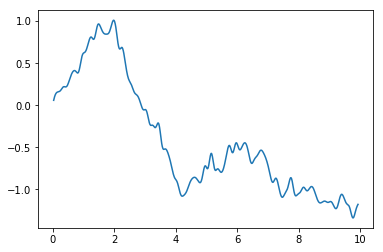

In [33]:
# Check if the training dataset is fed correctly
plt.plot(InputFset[0:990,0,-1], OutputFset[0:990].flatten())

Backup your model before it's too late...

In [77]:
# Save the entire model as a SavedModel.
!mkdir -p models/fma_framed_models
model.save('models/fma_framed_models/randomsin-20-nonoise-{0}-{1}-{2}-{3}'.format(Nlayer, Nneuron, frame_size, Epoch)) 

# Or: 
# Save the weights
# model.save_weights('./fma_framed_models/{0}-{1}-{2}-{3}'.format(Nlayer, Nneuron, frame_size, Epoch))

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
# loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

INFO:tensorflow:Assets written to: models/fma_framed_models/randomsin-20-nonoise-4-4-4-400/assets


# Check prediction performance by visualizing it

In [75]:
# Prepare test set
Nd_test_seg = 1000
u_func_list_test = u_func_list[0::2] + [
    # ======Below are unseen examples======
    lambda t : np.sin(0.3*t + 1.3),
    lambda t : 0.1*t, 
    lambda t : 0.28,
    lambda t : -0.2*t + 1.1,
    lambda t : (t-5.2)*(t-5.2)/50 - 0.2
]
Nseg_test = len(u_func_list_test)
dt = 0.01
t_list_test = np.array([[0,Nd_test_seg*dt]] * Nseg_test).T

(input_test, answer_test, seg_ind_list_test) = fma_batch_generator(
    t_list_test, u_func_list_test, dt=dt, noise_level=0
)
(input_f_test, answer_f_test, pred_f_test, test_ind_list) = framing(
    input_test, answer_test, seg_ind_list_test, frame_size=frame_size, pred_size=0
)

1


In [78]:
# Generate correct answer for each test, as well as run input through prediction
result = model.predict(input_f_test)

In [ ]:
# Hint: It might be worth it to save session before plotting.
# The notebook has died at plotting multiple times, which forces you to shut down the
# kernel and lose all data.
current_time = dt.datetime.now()
dill.dump_session('notebook_session-'+current_time.strftime("%m%d-%H:%M:%S")+'.db')

Text(0.5, 0.98, 'Model trained with 4 layers, each with 4 neurons, taking 4 recent samples')

<Figure size 432x288 with 0 Axes>

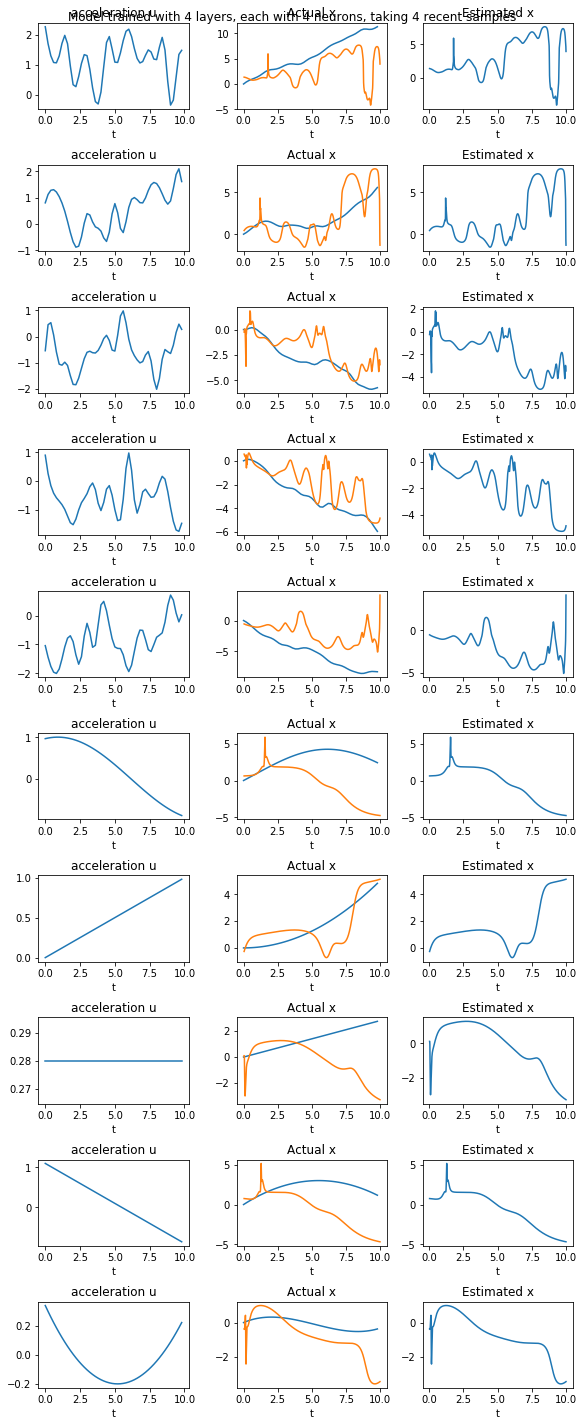

In [79]:
# Plot prediction 
plt.clf()
fig,axs = plt.subplots(Nseg_test, 3, constrained_layout=True, figsize = (8,2*Nseg_test))

# Skipped some of the samples to reduce load for pyplot (method: [::3] to take only every 3rd sample)
for i in range(Nseg_test):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    j0 = seg_ind_list_test[i]
    j1 = seg_ind_list_test[i+1]
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,::20], input_test[i][1,::20])
#     axs[i][0].plot(input_test[i][0,frame_size:], result[i0:i1,0]) # Overlay prediction onto previous plot
    axs[i][0].set_title('acceleration u')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,::20], answer_test[i][0,::20])
    axs[i][1].plot(input_test[i][0,frame_size:], result[i0:i1,0]) # Overlay prediction onto previous plot
#     axs[i][1].plot(input_test[i][0,frame_size:], answer_f_test[i0:i1,0]) # Test if the training frame is working properly
    axs[i][1].set_title('Actual x')
    axs[i][1].set_xlabel('t')
    axs[i][2].plot(input_test[i][0,frame_size:], result[i0:i1,0])#,None,:])
    axs[i][2].set_title('Estimated x')
    axs[i][2].set_xlabel('t')
fig.suptitle('Model trained with %d layers, each with %d neurons, taking %d recent samples' % (Nlayer, Nneuron, frame_size))

## One other thing we can explore is those models' ability to predict future inputs.
If they suck at this step, then there's no good reason to expect them to do well for outputs, am I right?

In [ ]:
# 4-layer, each with 4 neurons
train_prep()

# Generate data
frame_size = 4
pred_size = 1
(InputFset, OutputFset, PredictFset, train_ind_list) = framing(
    Inputset, Outputset, seg_ind_list, frame_size=frame_size, pred_size=pred_size)

Activation = tf.keras.activations.tanh
Nneuron = 4
model_p1 = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(Nneuron, activation = Activation, input_shape = (InputFset.shape[1],InputFset.shape[2])),
    tf.keras.layers.Flatten(), # Should it be here? Immediately flatten input to 1D?
    tf.keras.layers.Dense(Nneuron, activation = Activation), 
    tf.keras.layers.Dense(Nneuron, activation = Activation), 
    tf.keras.layers.Dense(Nneuron, activation = Activation), 
    tf.keras.layers.Dense(InputFset.shape[1])  # Output
])
Nlayer = 4
Epoch = 250

# Loss function: Use the simplest squared error for now
model_p1.compile(optimizer = 'adam', loss = tf.keras.losses.mean_squared_error)

# Train
history = model_p1.fit(InputFset, PredictFset, epochs=Epoch, callbacks=[tensorboard_callback])
model_p1.summary()


In [ ]:
# Check its performance
Nd_test_seg = 1200
u_func_list_test = u_func_list[:5] + [
    # ======Below are unseen examples======
    lambda t : np.sin(0.3*t + 1.3),
    lambda t : 0.1*t, 
    lambda t : 0.28,
    lambda t : -0.4*t + 0.5,
    lambda t : (t - 1.2)*(t-1.2)/10 - 0.2
]
Nseg_test = len(u_func_list_test)
dt = 0.01
t_list_test = np.array([[0,Nd_test_seg*dt]] * Nseg_test).T

(input_test, answer_test, seg_ind_list_test) = fma_batch_generator(
    t_list_test, u_func_list_test, dt=dt, noise_level=0
)
(input_f_test, answer_f_test, pred_f_test, test_ind_list) = framing(
    input_test, answer_test, seg_ind_list_test, frame_size=frame_size, pred_size=pred_size
)
# Visualize for future inputs
fig,axs = plt.subplots(Nseg_test, 2, constrained_layout=True, figsize = (10,2*Nseg_test))
pred_size=1
result = model_p1.predict(input_f_test)
for i in range(Nseg_test):
    i0 = test_ind_list[i]
    i1 = test_ind_list[i+1]
    # Plot both correct answer and prediction
    axs[i][0].plot(input_test[i][0,:], input_test[i][1,:])
    axs[i][0].plot(result[i0:i1,0], result[i0:i1,1])
    axs[i][0].set_title('Input, actual and predicted')
    axs[i][0].set_xlabel('t')
    axs[i][1].plot(input_test[i][0,frame_size+pred_size:], result[i0:i1,0])
    axs[i][1].set_title('Estimated next timesteps')
    axs[i][1].set_xlabel('t')

## Inspect net structure

In [80]:
%tensorboard --logdir fma_framed_logs/fit #--host localhost
# Add "--ohst localhost" only when having previous session and not running from a fresh notebook

Reusing TensorBoard on port 6008 (pid 44863), started 0:34:08 ago. (Use '!kill 44863' to kill it.)

## Can we see what's happening inside the layer?

In [81]:
print(model.get_layer('dense').weights) # Input layer
print(model.get_layer('dense_1').weights)
print(model.get_layer('dense_2').weights)
print(model.get_layer('dense_3').weights)
print(model.get_layer('dense_4').weights) # Output layer
# model.get_layer('dense_1').output

[<tf.Variable 'sequential/dense/kernel:0' shape=(8, 4) dtype=float32, numpy=
array([[ 0.6541177 ,  0.40969467, -0.26375124, -0.18646872],
       [ 0.6851618 ,  0.03923557,  0.13856508,  0.10567554],
       [ 0.62273026,  0.2935104 , -0.01795286,  0.0251259 ],
       [ 0.08314577, -0.48773512,  0.0517908 , -0.12693693],
       [-0.7982421 , -0.72942847,  1.575818  , -0.48956007],
       [-1.1367669 , -0.4116156 ,  0.40244606,  0.43051347],
       [-0.86096686,  0.5467505 ,  0.06778909, -0.21787065],
       [-0.7369452 ,  0.29633793, -0.32469225, -0.5655478 ]],
      dtype=float32)>, <tf.Variable 'sequential/dense/bias:0' shape=(4,) dtype=float32, numpy=array([ 0.31087837, -1.0335395 ,  0.10956481,  1.4271722 ], dtype=float32)>]
[<tf.Variable 'sequential/dense_1/kernel:0' shape=(4, 4) dtype=float32, numpy=
array([[ 1.0715028 , -0.46491814,  0.50852215,  0.8674126 ],
       [-0.98702663, -0.06095626,  0.9662098 , -0.8184762 ],
       [-0.2685933 ,  0.9762114 , -1.5123852 ,  0.94800794],
 

In [ ]:
# Ref: https://stackoverflow.com/a/48966702 & https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer
earlyPred = tf.keras.Model(model.input, model.get_layer('dense_4').output)
# Other things to extract what's inside.

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 4)              20        
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
__________________________________________________________

## ---Draft area---

In [ ]:
fff = [(lambda x:x+1), (lambda x:x*2), (lambda x:x-3)]
print(fff[0](2), fff[1](2), fff[2](2))

In [75]:
%reset model_p1

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Don't know how to reset  model_p1, please run `%reset?` for details


In [ ]:
bbb = [1,2,3,4,5,6,7,9,8]
bbb[1:8:3]

In [50]:
!kill 44093

/bin/sh: line 0: kill: (44093) - No such process
